In [1]:
import numpy as np
import patsy
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import minimize
from scipy.integrate import quad
from findpeaks import findpeaks
from quadprog import solve_qp

In [2]:
from module.auto_peak_valley import Peak_Valley_Simu, IsotonicReg, constrained_splines_reg, comprehensive_csr
from module.knot_func import *

### 模擬用的函式 $ sin\left( \frac{(4x)^2}{2} \ln{(4x)^3} \right) $

In [3]:
def f(x):
    return np.sin(0.5*(4*x)**2 * np.log((4*(x+0.0001))**3))

In [4]:
np.random.seed(42)
x = np.linspace(0, 1, 1000).round(5)
y = f(x) + np.random.normal(scale=0.3, size=(1000,))

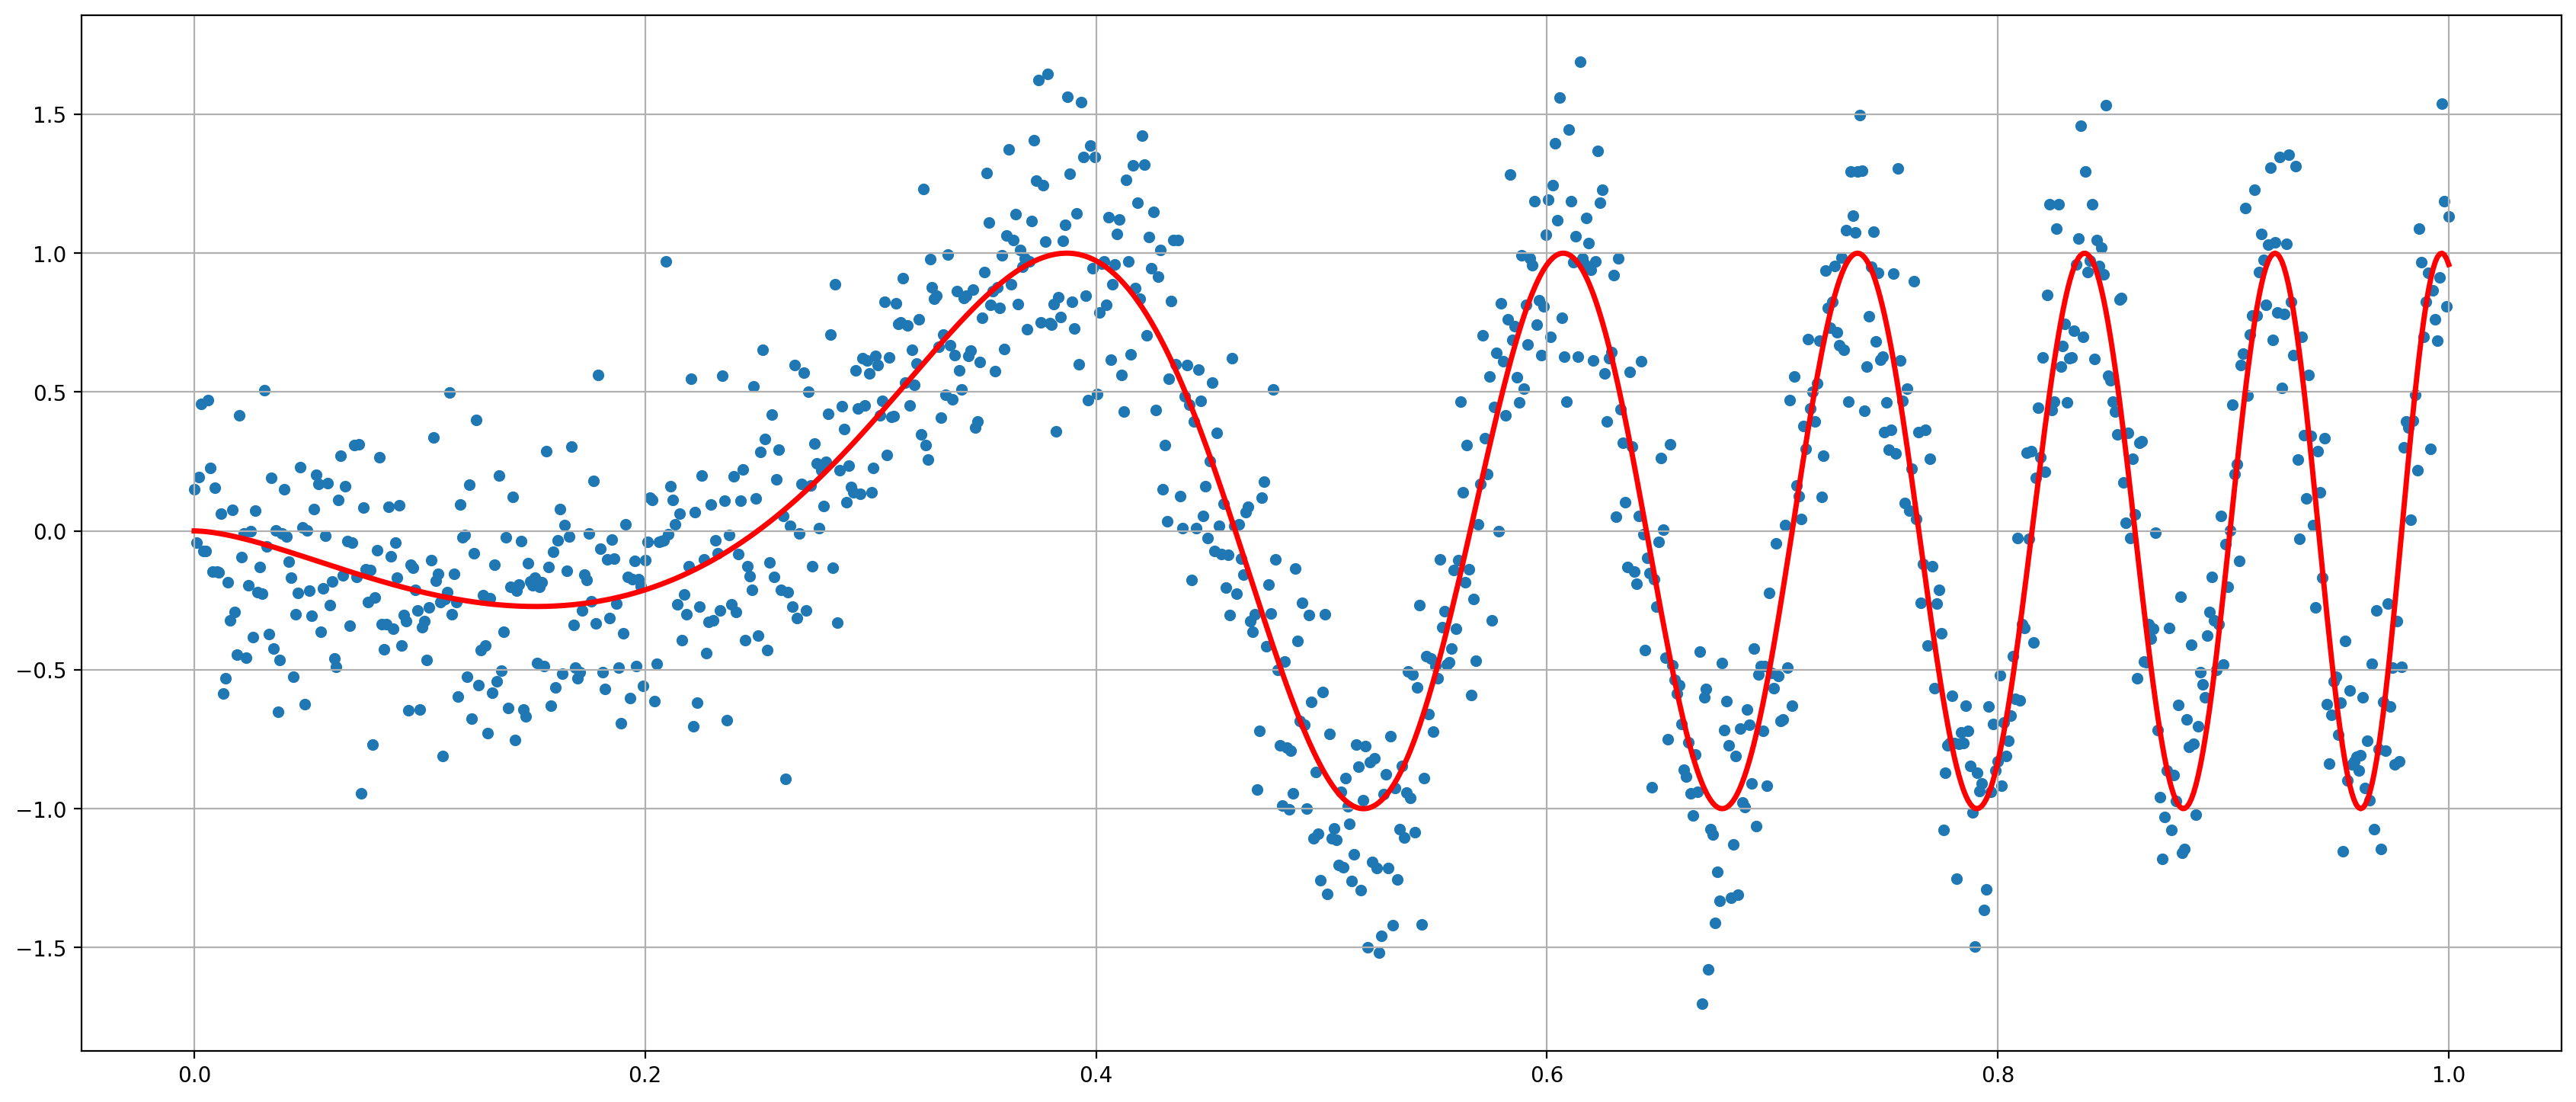

In [5]:
plt.figure(figsize=(21, 9), dpi=200)
plt.scatter(x, y, s=20)
plt.plot(x, f(x), c="r", linewidth=2.5)
plt.grid()
plt.show()

### 使用自己的方法找峰谷位置

In [6]:
multi_peak = Peak_Valley_Simu()
multi_peak.x, multi_peak.y = x, y

In [7]:
auto_multi_init_demarcation, auto_multi_peak_detection_result, auto_multi_peak_detection_dict = \
    multi_peak.auto_peak_points_detection_v3(step=0.02, distance=0.085, iter_scale=1)
print("峰座標：", auto_multi_peak_detection_result)
print(auto_multi_init_demarcation)

auto_multi_initvalley_demarcation, auto_multi_valley_detection_result, auto_multi_valley_detection_dict = \
    multi_peak.auto_valley_points_detection(step=0.02, distance=0.06, iter_scale=1)
print("谷座標：", auto_multi_valley_detection_result)

峰座標： deque([0.4004, 0.61962, 0.73974, 0.81982, 0.91992])
deque([0.73974], maxlen=1)
谷座標： deque([0.51952, 0.67968, 0.7998, 0.87988, 0.95996])


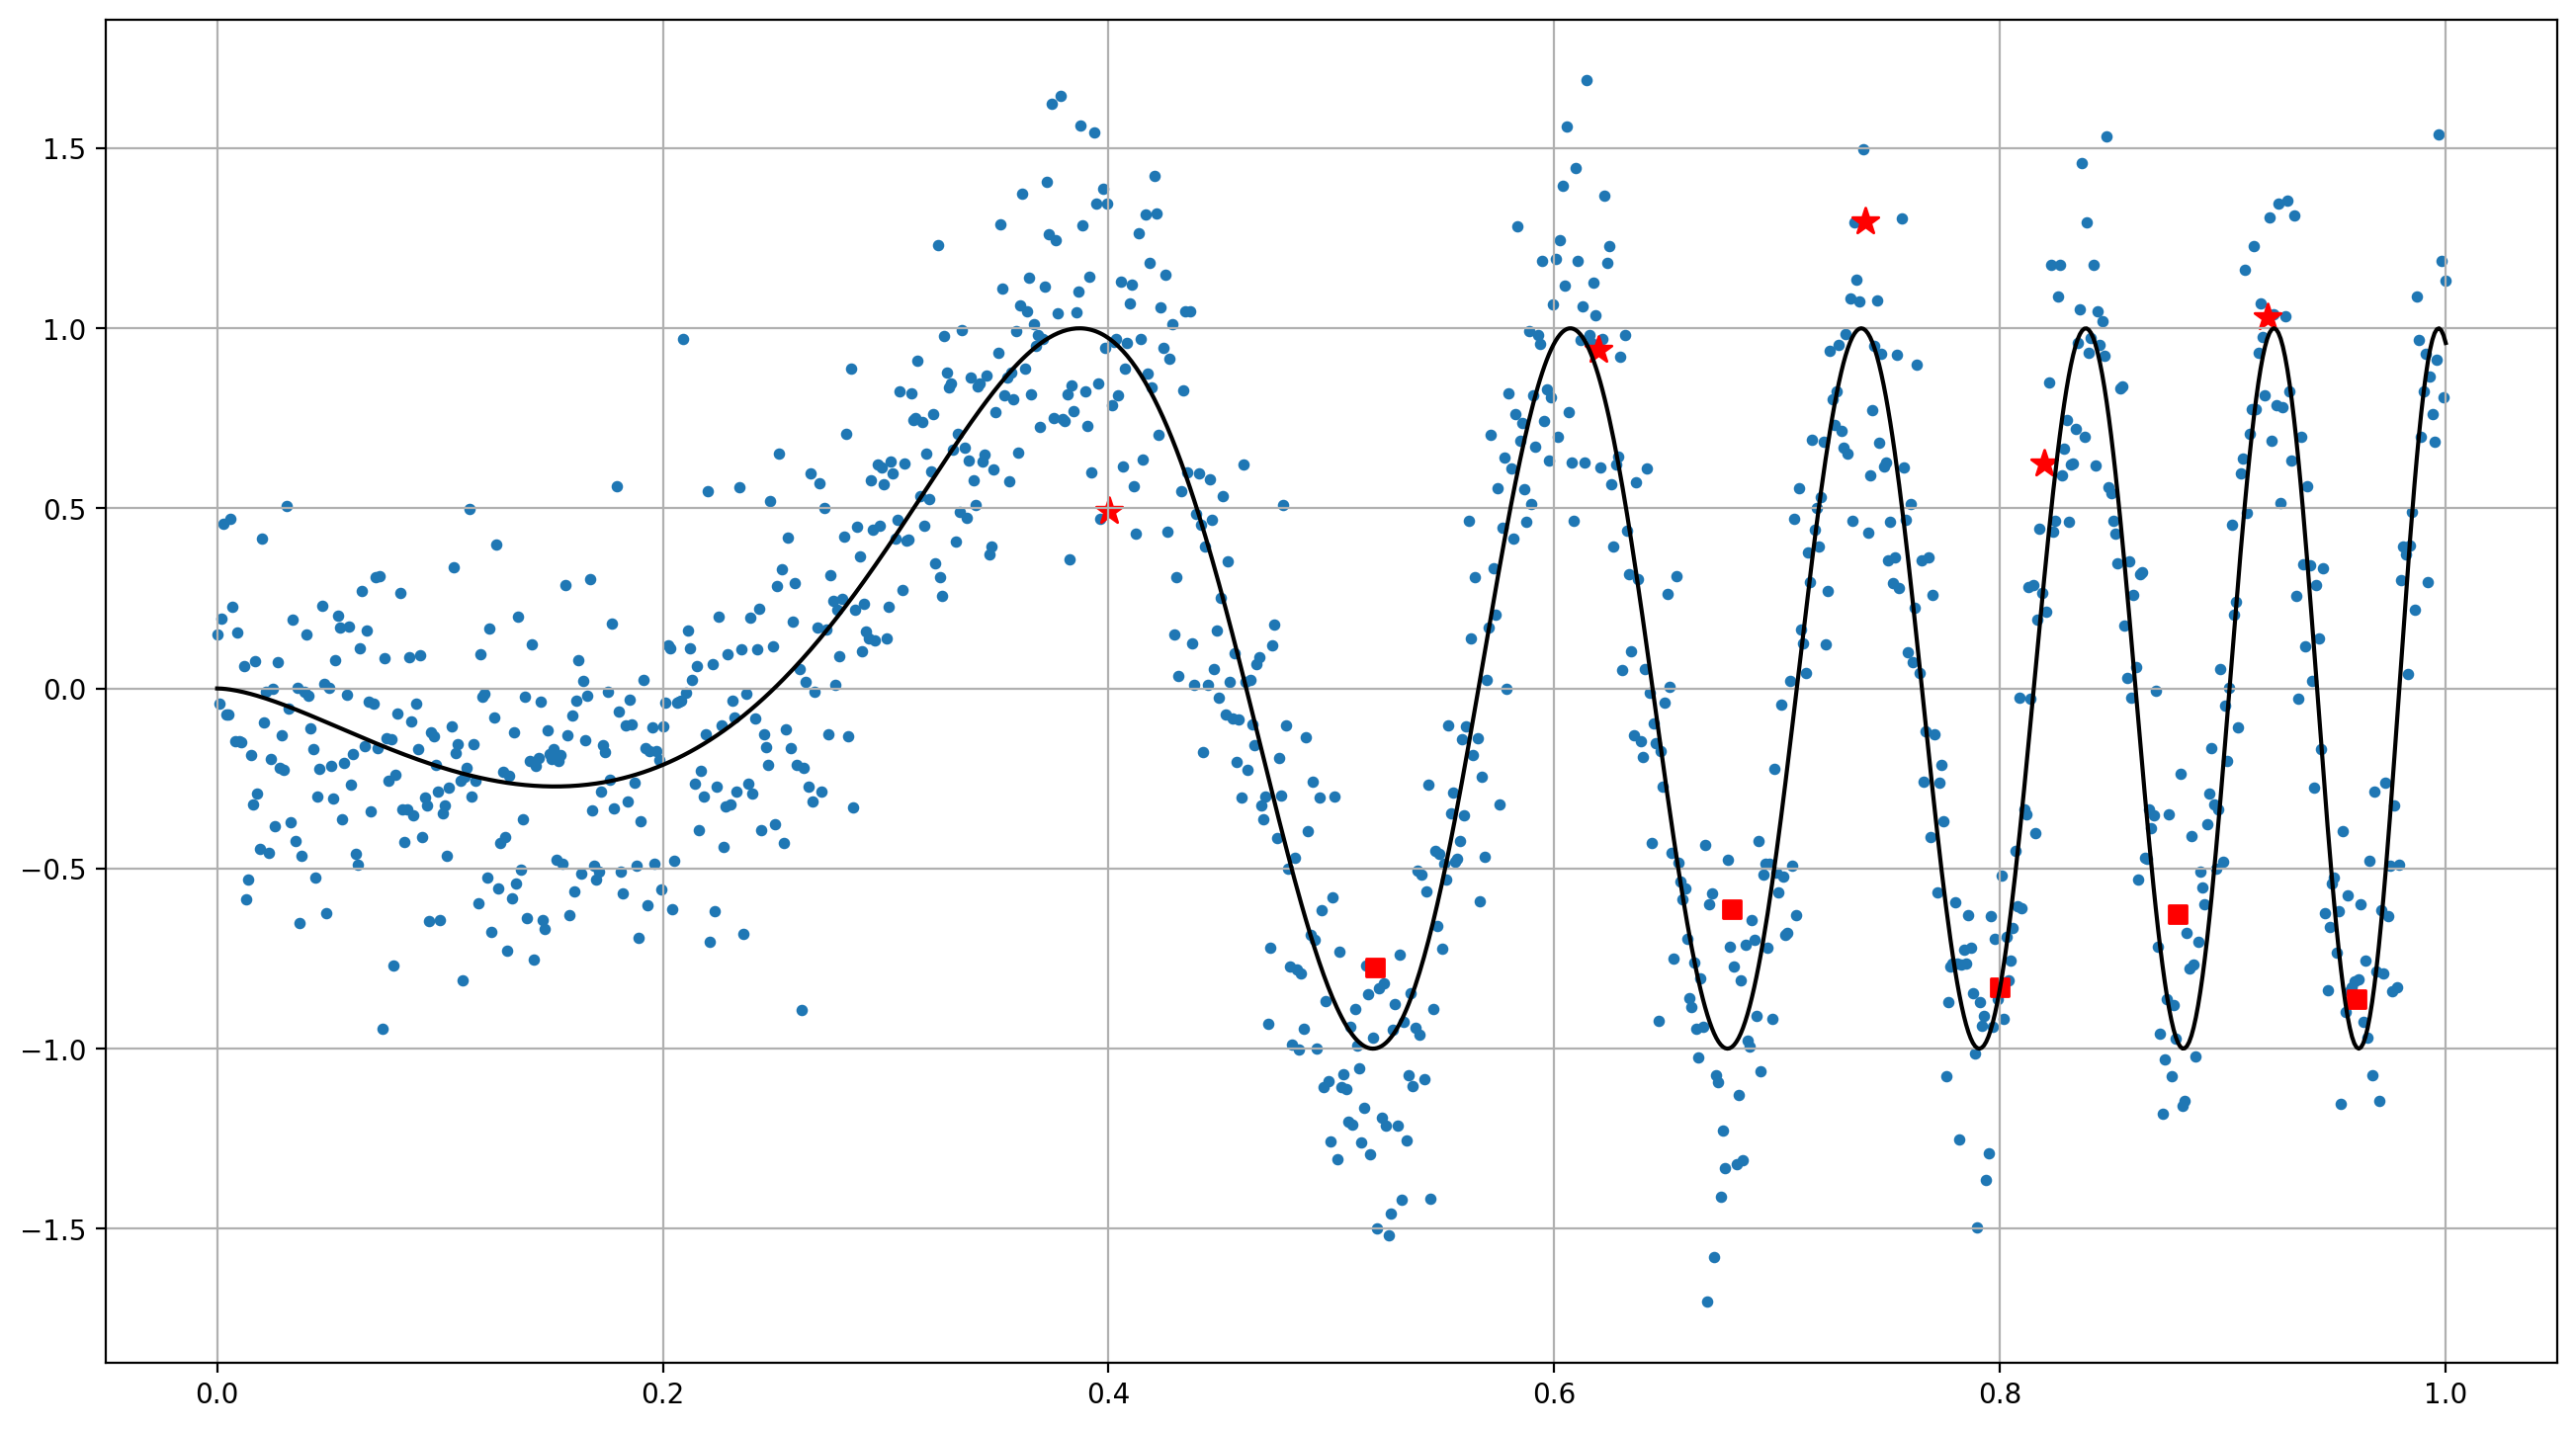

In [8]:
peak_x = list(auto_multi_peak_detection_result)
peak_y = y[[x.tolist().index(i) for i in peak_x]]
valley_x = list(auto_multi_valley_detection_result)
valley_y = y[[x.tolist().index(i) for i in valley_x]]
plt.figure(figsize=(16,9), dpi=200)
plt.scatter(x, y, s=10)
plt.plot(x, f(x), c="k")
plt.scatter(peak_x, peak_y, s=100, c="r", marker='*')
plt.scatter(valley_x, valley_y, s=45, c="r", marker='s')
plt.grid()
plt.show()

In [9]:
def to_softmax_v2(pv_coordinate: list): # 搞錯的 multi-class logistic reg 作法
    pv_coordinate_copy = np.array(pv_coordinate)
    output = pv_coordinate_copy / sum(pv_coordinate_copy)
    return output # array

def reverse_softmax_v2(pv_coordinate_softmax_form, x=x): # 搞錯的 multi-class logistic reg 作法
    pv_coordinate_original_form = 0.73974*(1/pv_coordinate_softmax_form[4])*pv_coordinate_softmax_form
    # print(pv_coordinate_original_form)
    nearest_x = [min(x, key=lambda k: abs(k-j)) for j in pv_coordinate_original_form]
    nearest_x_index = [list(x).index(i) for i in nearest_x]
    nearest_x_index = [0] + nearest_x_index + [999]
    return nearest_x_index

def to_softmax_v3(pv_coordinate, base=0): # 最終版的 multi-class logistic reg 作法
    pv_coordinate_copy = np.hstack((x[0], np.array(pv_coordinate), x[-1]))
    pv_coordinate_copy2 = np.diff(pv_coordinate_copy)
    log_odds = np.log(pv_coordinate_copy2 / pv_coordinate_copy2[base])
    return log_odds

def reverse_softmax_v3(pv_coordinate_softmax_form): # 最終版的 multi-class logistic reg 作法
    # pv_coordinate_original_form = np.exp(pv_coordinate_softmax_form) * 0.24024
    # pv_coordinate_original_form = pv_coordinate_original_form.cumsum()[:-1]
    pv_coordinate_base_form = 1 / np.sum(np.exp(pv_coordinate_softmax_form))
    pv_coordinate_original_form = np.hstack((pv_coordinate_base_form, pv_coordinate_base_form*np.exp(pv_coordinate_softmax_form[1:]))).cumsum()
    pv_coordinate_original_form = pv_coordinate_original_form[:-1]
    nearest_x = [min(x, key=lambda k: abs(k-j)) for j in pv_coordinate_original_form]
    nearest_x_index = [list(x).index(i) for i in nearest_x]
    nearest_x_index = [0] + nearest_x_index + [999]
    return nearest_x_index

In [10]:
pv, pv_index = multi_peak.peak_valley_index()
pv_coordinate_softmax_transform = to_softmax_v3(pv)
print("峰谷座標：", pv, "\n", "峰谷索引：", pv_index, sep="")
print("-"*50)
print("轉換後座標：", pv_coordinate_softmax_transform)

峰谷座標：[0.4004, 0.51952, 0.61962, 0.67968, 0.73974, 0.7998, 0.81982, 0.87988, 0.91992, 0.95996]
峰谷索引：[0, 400, 519, 619, 679, 739, 799, 819, 879, 919, 959, 999]
--------------------------------------------------
轉換後座標： [ 0.         -1.21233266 -1.38629436 -1.89711998 -1.89711998 -1.89711998
 -2.99573227 -1.89711998 -2.30258509 -2.30258509 -2.30258509]


In [11]:
print(reverse_softmax_v3(pv_coordinate_softmax_transform))

[0, 400, 519, 619, 679, 739, 799, 819, 879, 919, 959, 999]


RSS:  68.57873238916383


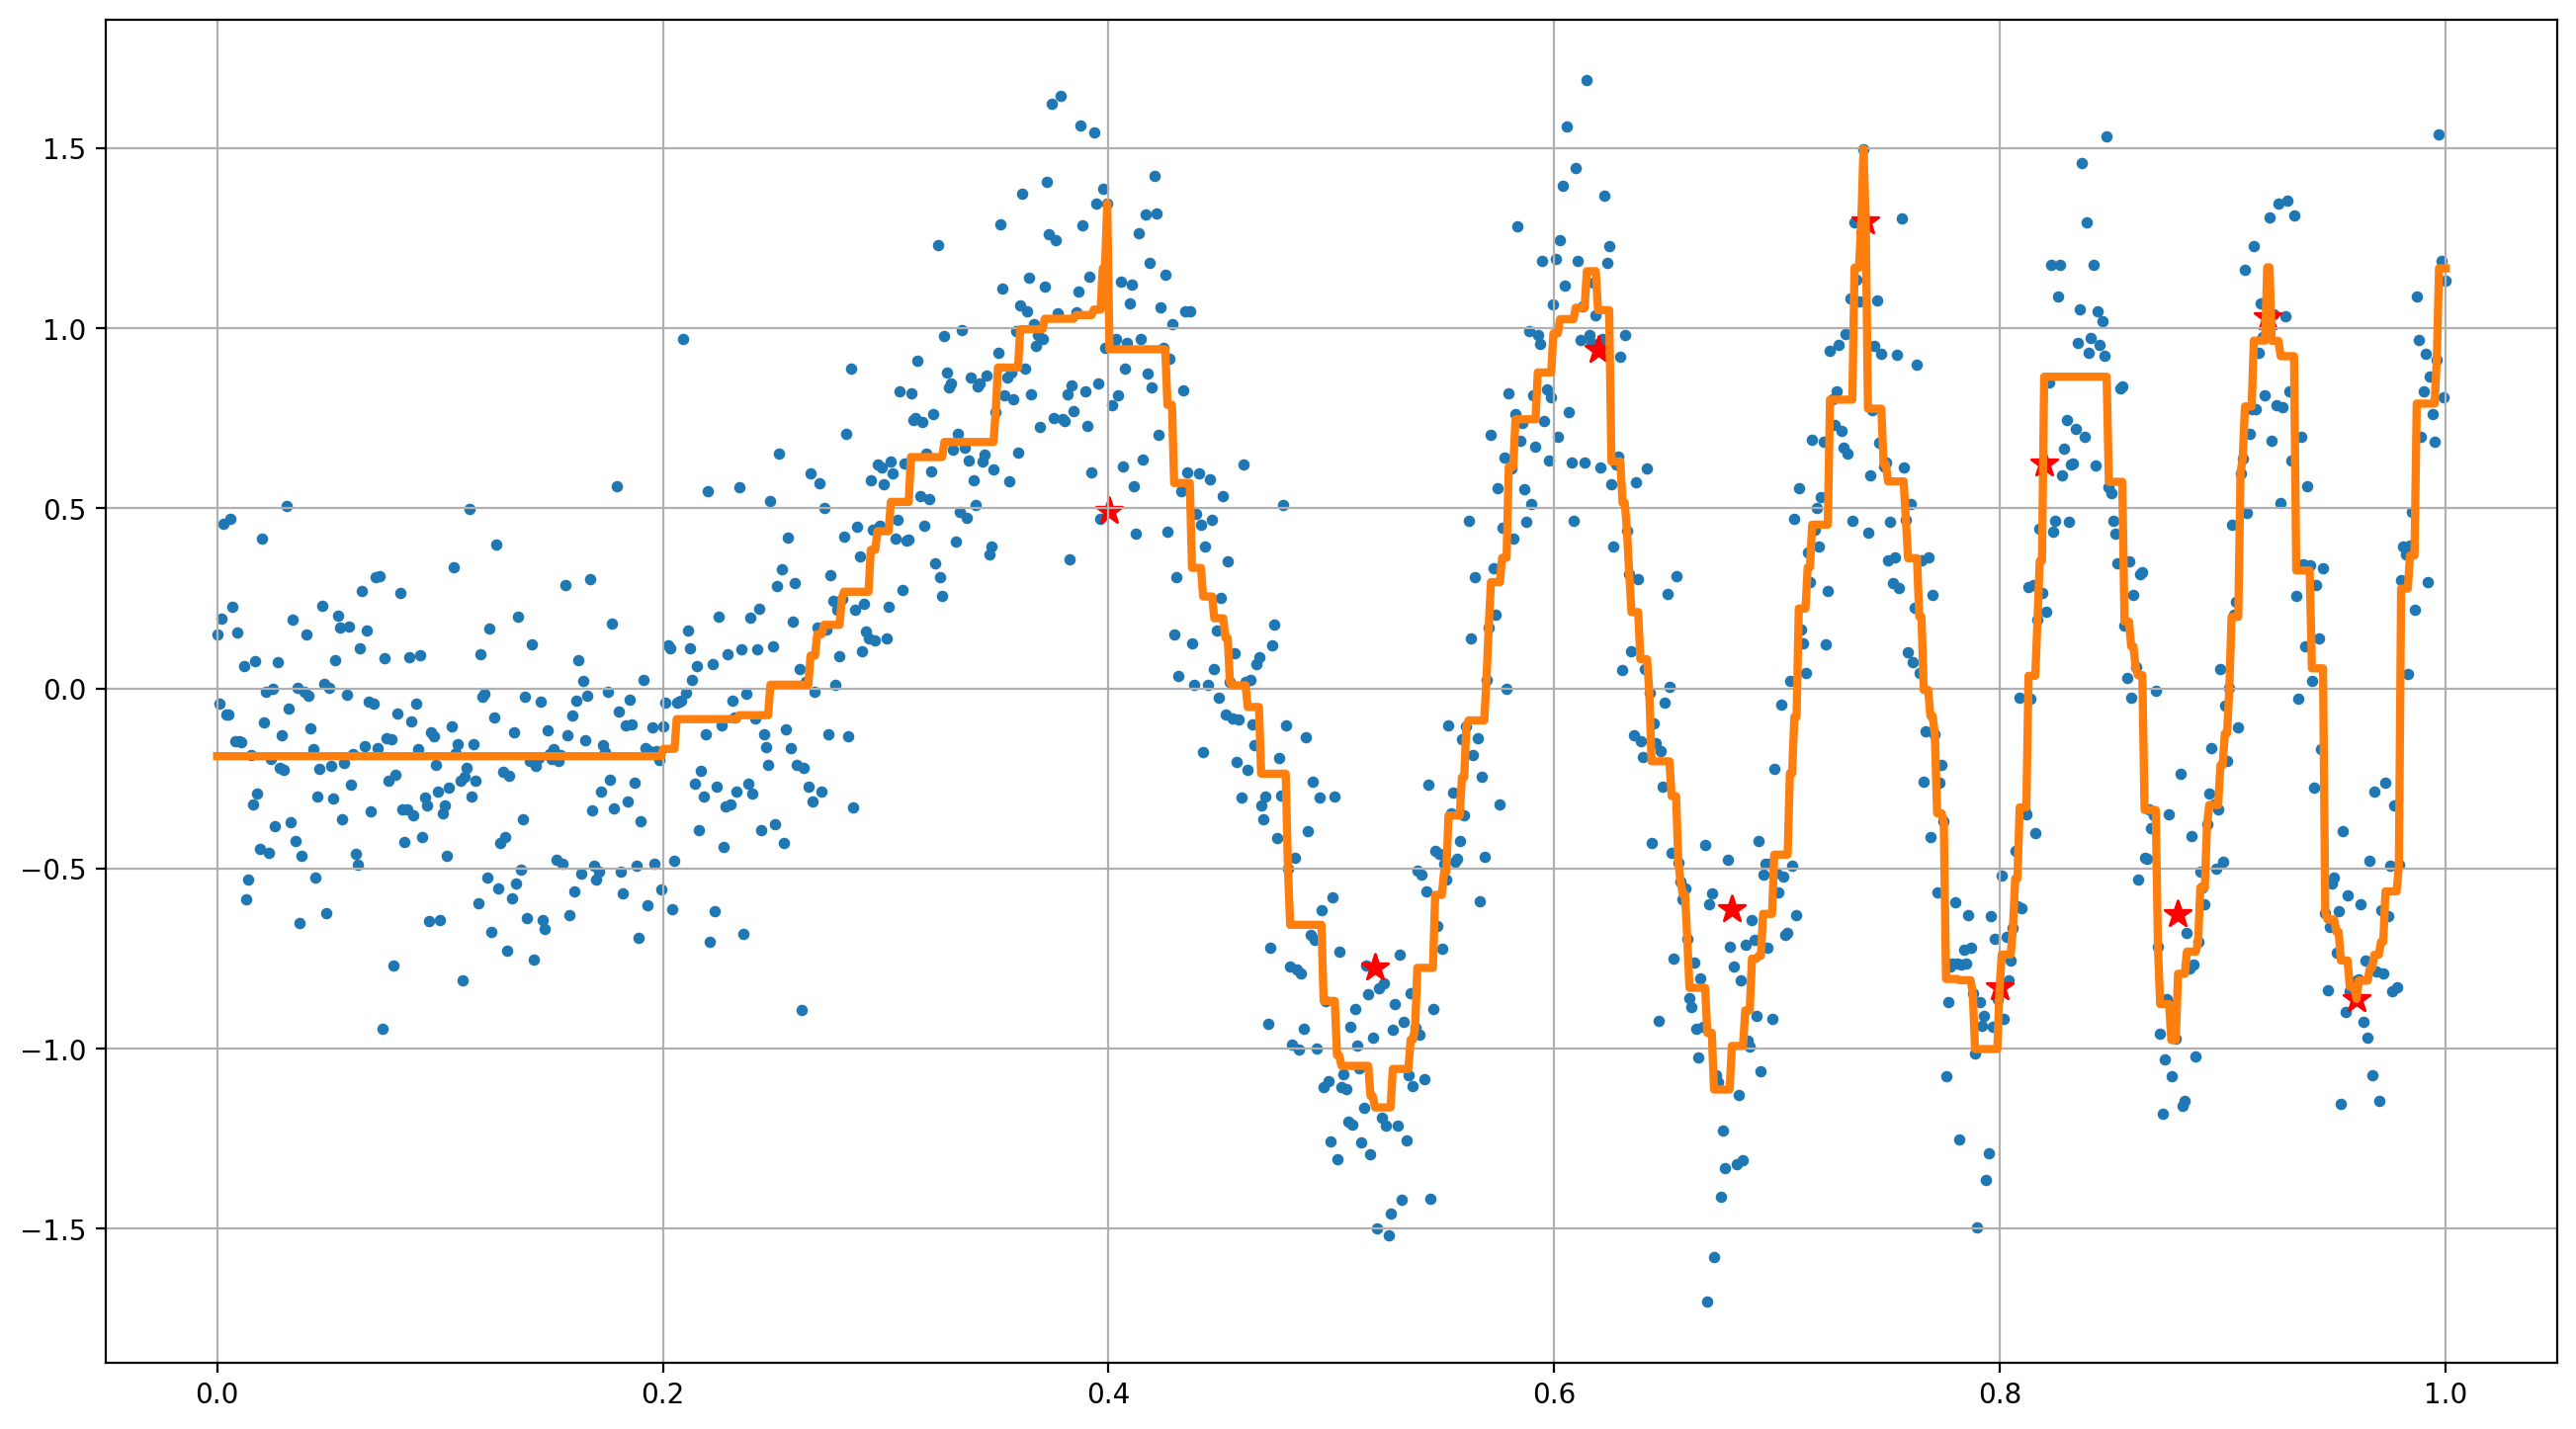

In [12]:
multi_pv_isoreg = IsotonicReg(x=x, y=y, pv_index=pv_index)
multi_pv_isoreg.iso_fit_transform()
print("RSS: ", multi_pv_isoreg.isotonic_rss())
multi_pv_isoreg.plot_isoreg()

In [13]:
# minimize_result = minimize(
#     multi_peak.isotonic_reg_rss_v3, pv_coordinate_softmax_transform,
#     method="Nelder-Mead", options={"adaptive": True}
# )
# np.save(".\\weights\\minimize_simulation3_x", minimize_result.x)

In [14]:
minimize_result = np.load(".\\weights\\minimize_simulation3_x.npy")
print(minimize_result)

[ 1.85953766e-04 -1.19612532e+00 -1.45372041e+00 -1.86558936e+00
 -1.85956701e+00 -1.86428553e+00 -2.91990587e+00 -1.88645181e+00
 -2.31785820e+00 -2.34242214e+00 -2.32599895e+00]


In [15]:
new_pv = x[reverse_softmax_v3(minimize_result)]
new_pv_index = reverse_softmax_v3(minimize_result)
print(new_pv)
print(new_pv_index)

[0.      0.4004  0.52152 0.61461 0.67668 0.73874 0.8008  0.82282 0.88288
 0.92192 0.96096 1.     ]
[0, 400, 521, 614, 676, 738, 800, 822, 882, 921, 960, 999]


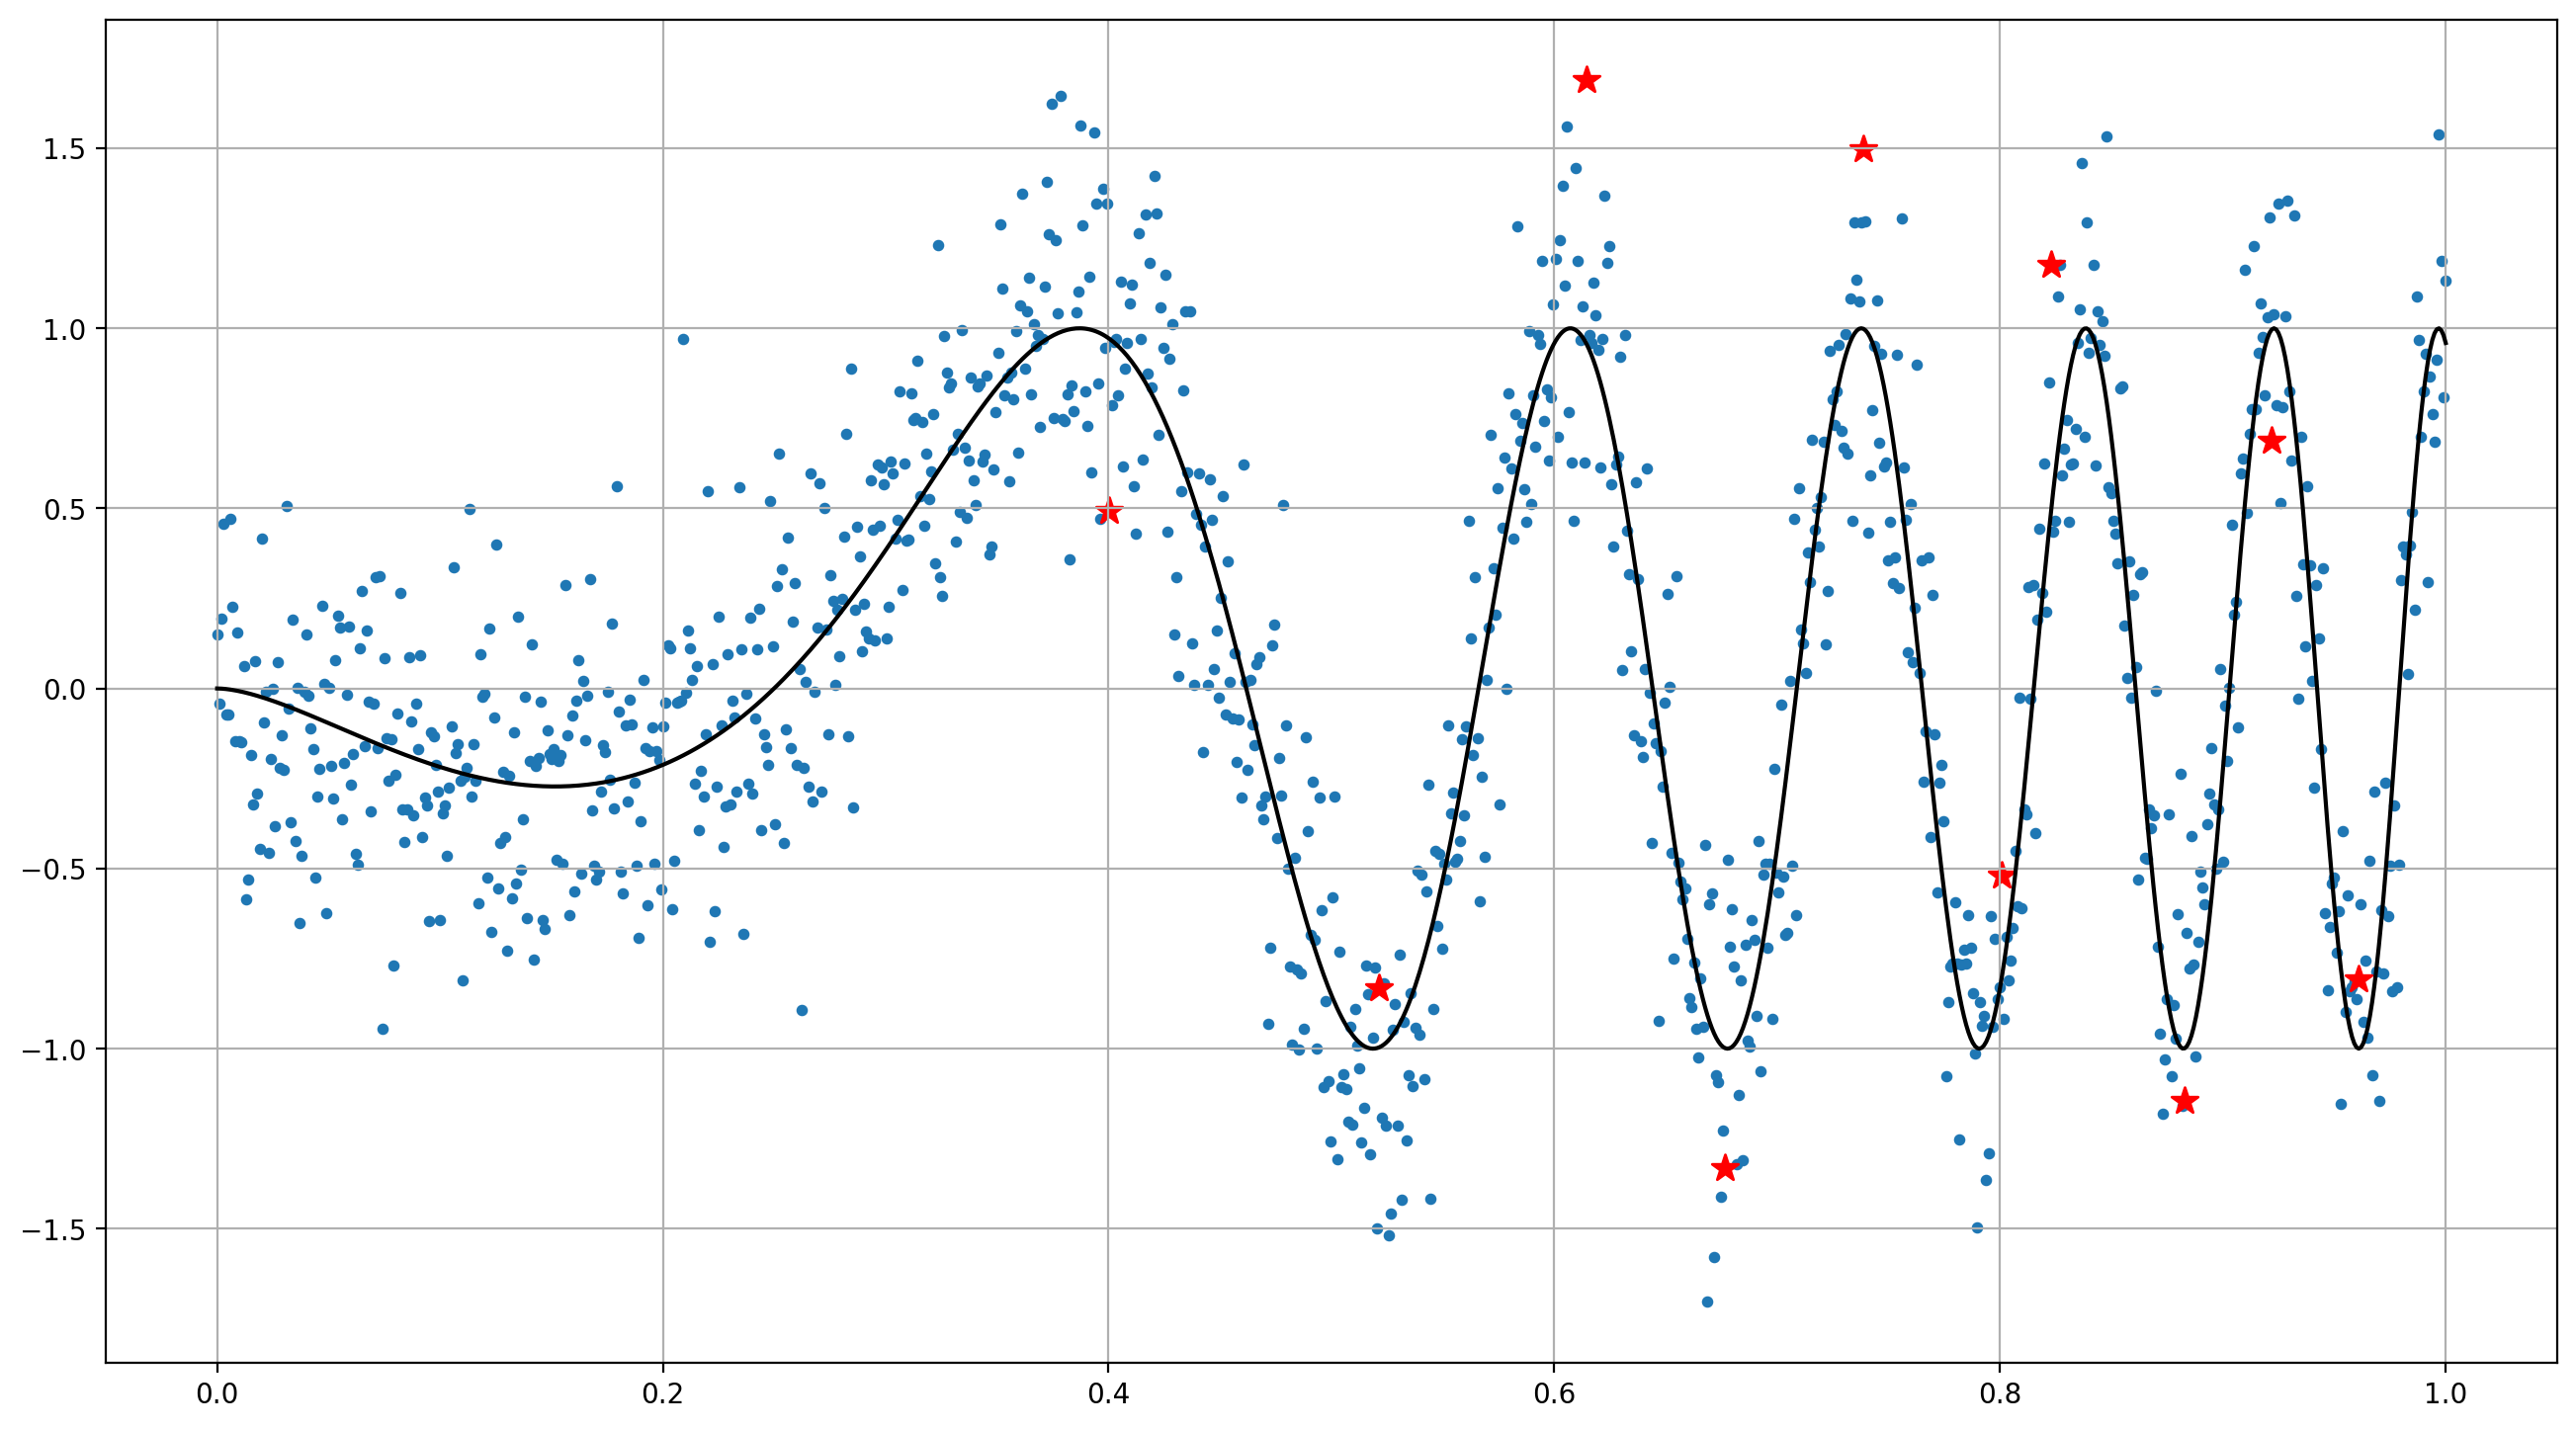

In [16]:
plt.figure(figsize=(16,9), dpi=200)
plt.scatter(x, y, s=10)
plt.plot(x, f(x), c="k")
plt.scatter(x[new_pv_index[1:-1]], y[new_pv_index[1:-1]], s=100, c="r", marker='*')
plt.grid()
plt.show()

RSS:  66.91268683876643


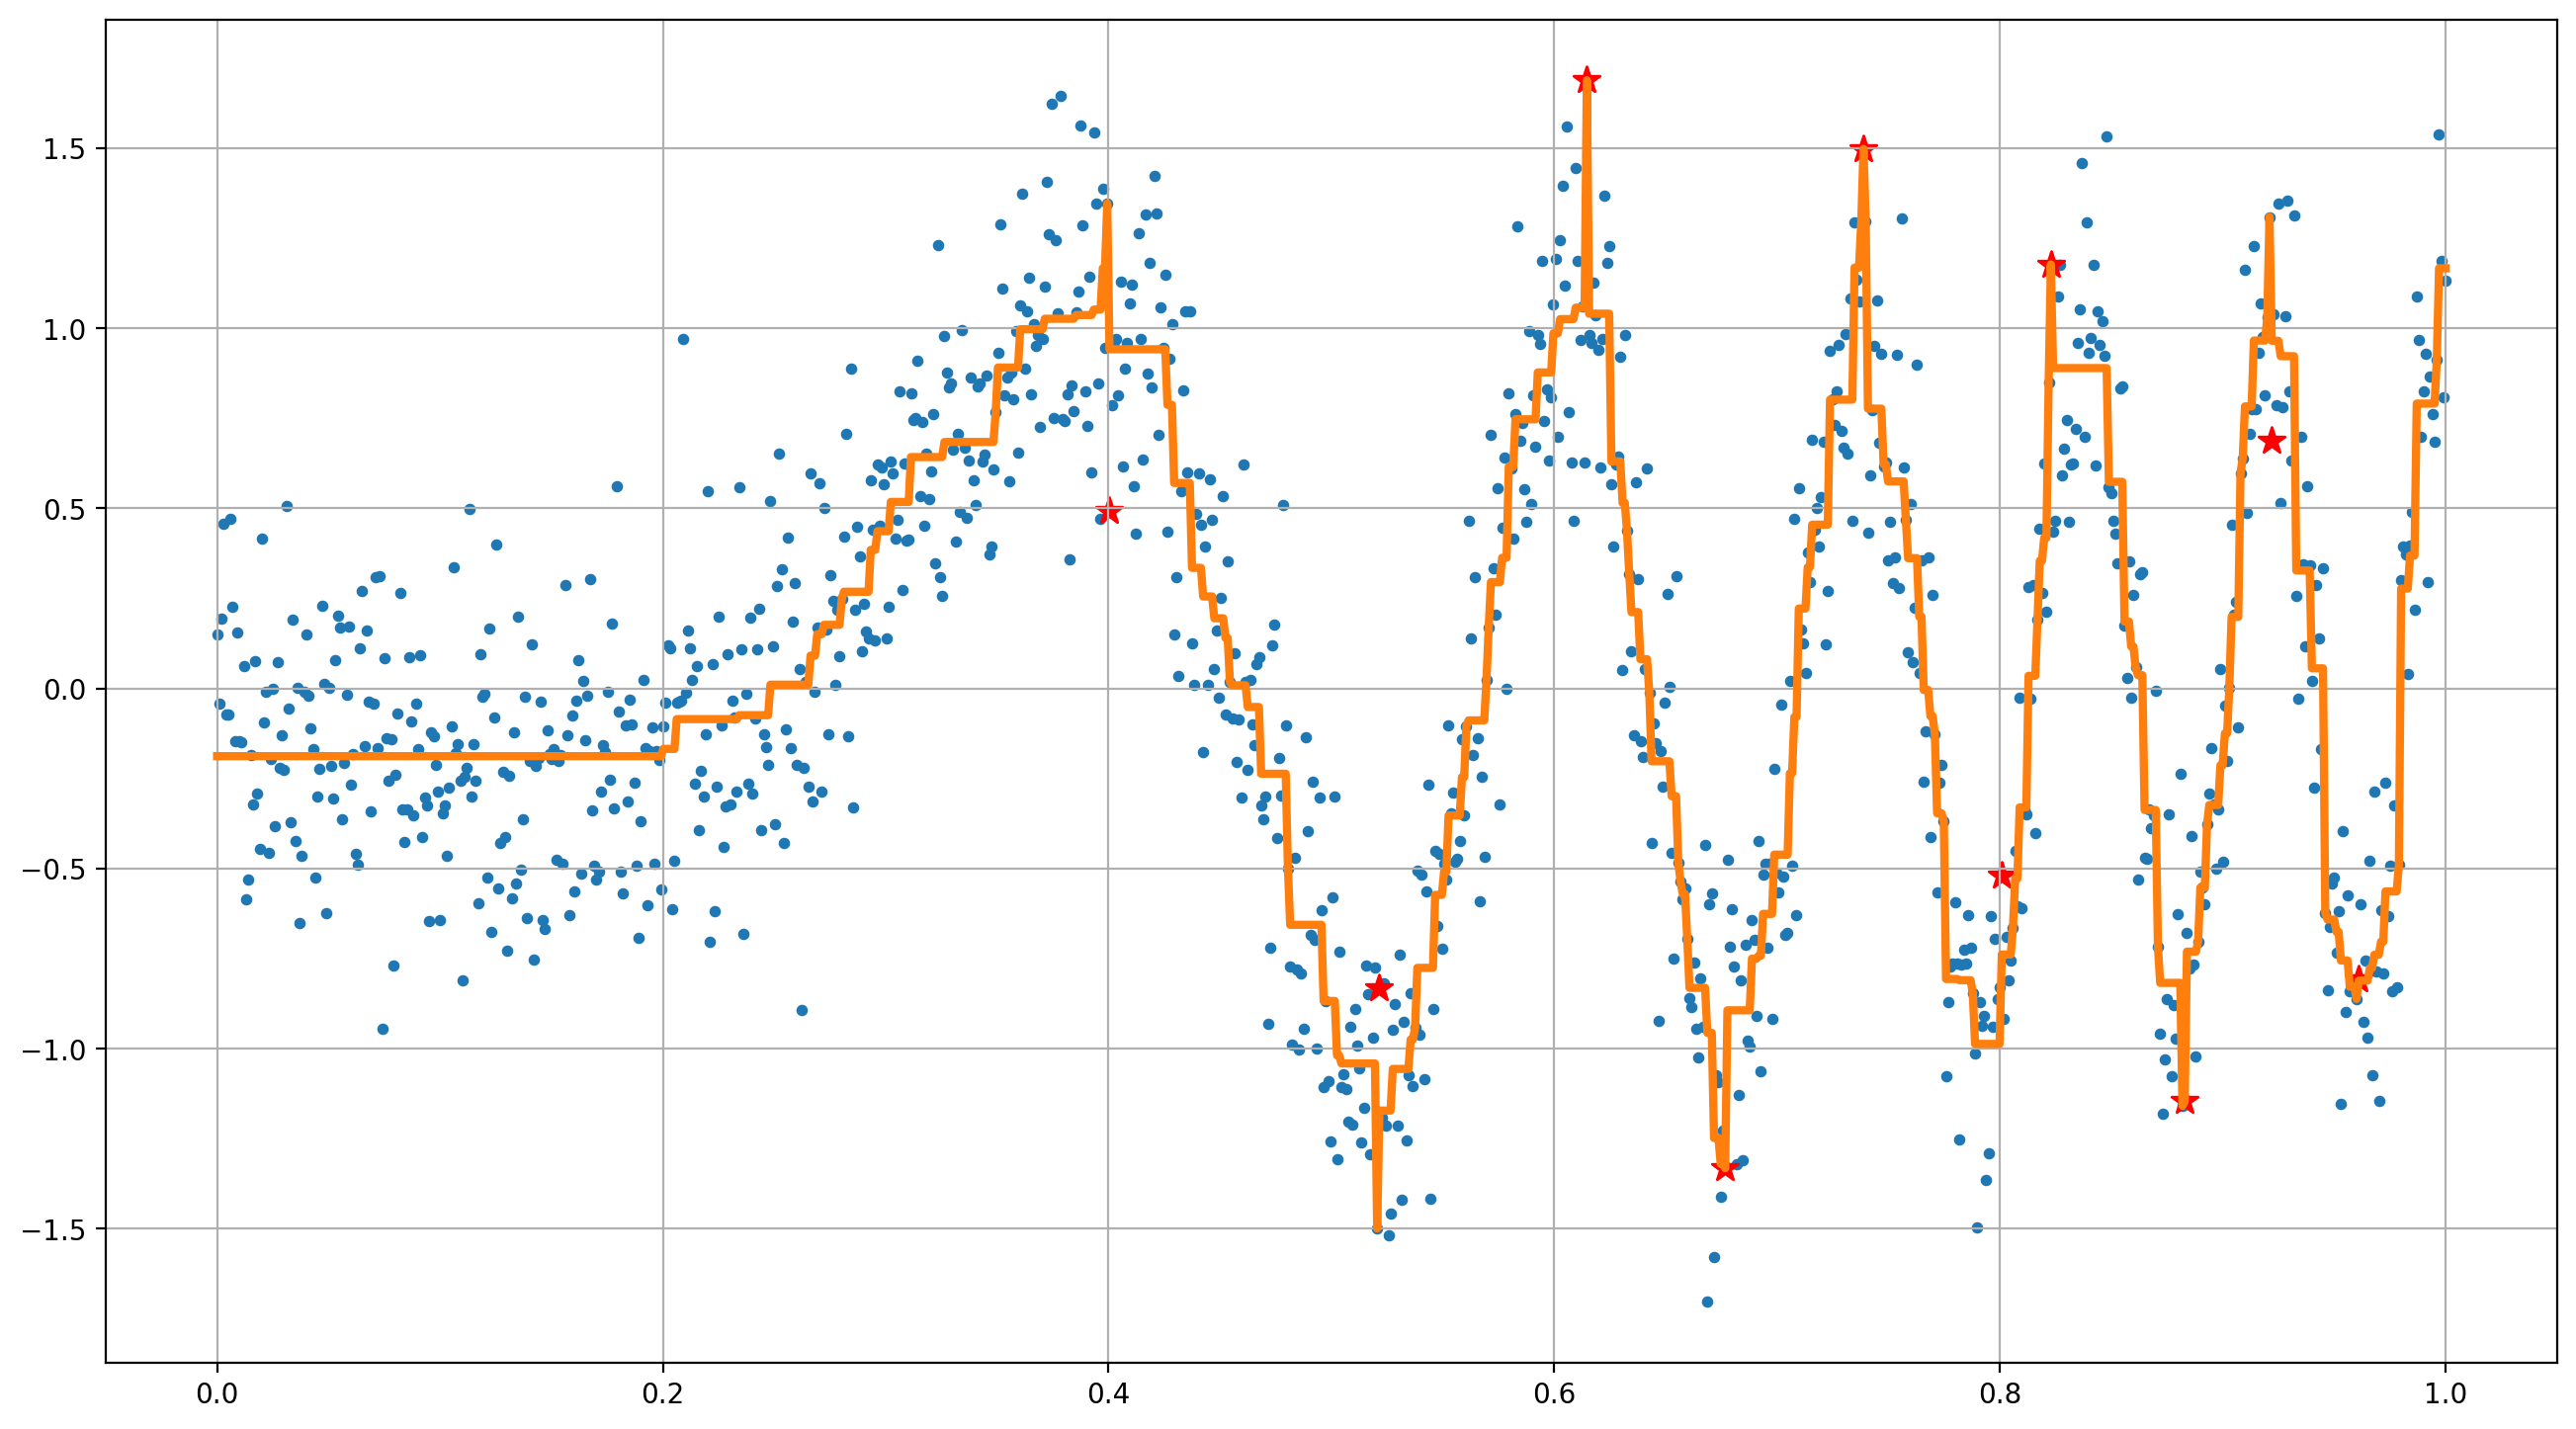

In [17]:
multi_tuned_pv_isoreg = IsotonicReg(x=x, y=y, pv_index=new_pv_index)
multi_tuned_pv_isoreg.iso_fit_transform()
print("RSS: ", multi_tuned_pv_isoreg.isotonic_rss())
multi_tuned_pv_isoreg.plot_isoreg()

In [18]:
knots = get_knot(x, y)
knots

array([0.67768, 0.74074, 0.60761, 0.84885, 0.97097, 0.52352, 0.3964 ,
       0.25926, 0.02002, 0.32232, 0.12513, 0.18819])

In [19]:
compre_csr1 = comprehensive_csr(x=x, y=y, pv_coordinate=new_pv[1:-1], pv_index=new_pv_index, knots_of_each_part=knots)

In [20]:
y_constrained_result = compre_csr1.fit_constrained_transform(deg=3, meq=4, first_part_increase=True)
y_result = compre_csr1.fit_transform(deg=2)

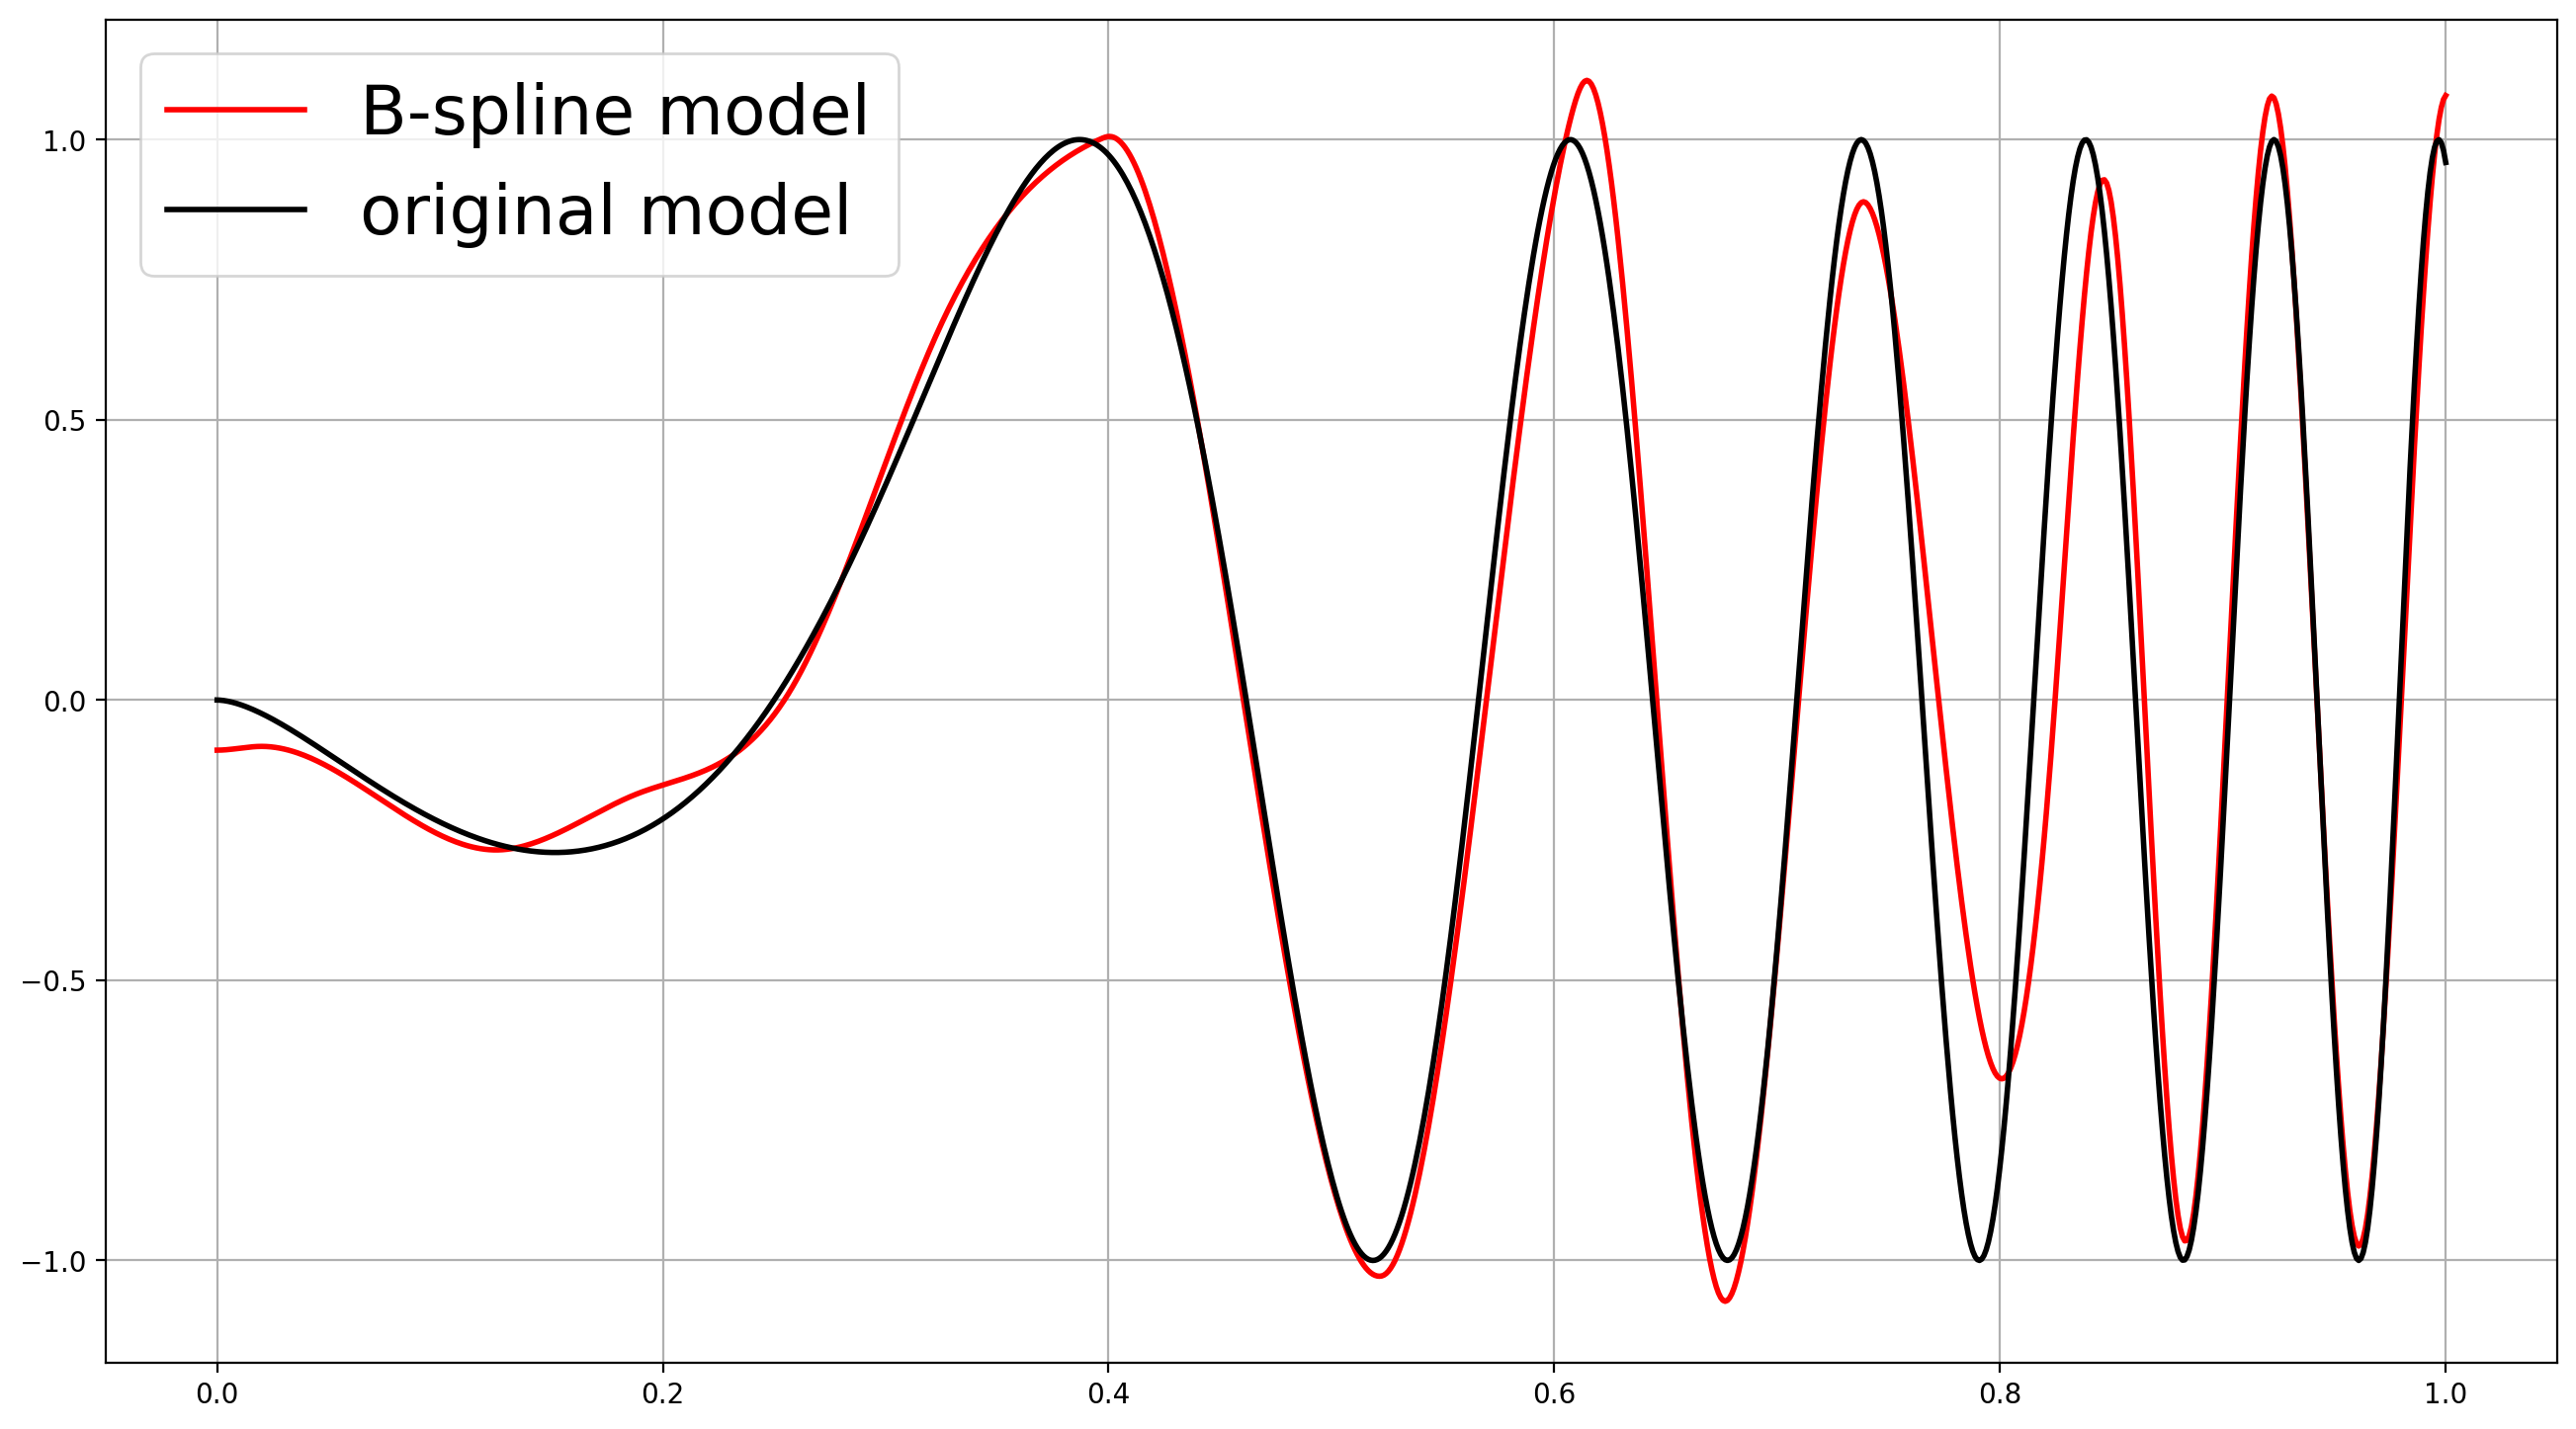

MSE:  0.10127742684966615
MSE:  0.10125510613303429


In [21]:
plt.figure(figsize=(16,9), dpi=200)
# plt.scatter(x, y, s=10)
plt.plot(x, y_constrained_result, c="r", label="B-spline model", linewidth=2)
# plt.plot(x, y_result, c="tab:orange", label="unconstrained model")
plt.plot(x, f(x), c="k", label="original model", linewidth=2)
plt.legend(fontsize=25)
plt.grid()
plt.show()
print("MSE: ", ((y_constrained_result.reshape((-1,)) - y)**2).mean())
print("MSE: ", ((y_result.reshape((-1,)) - y)**2).mean())

In [22]:
print("RSS: ", ((y_constrained_result.reshape((-1,)) - f(x))**2).mean())

RSS:  0.018768382581659738


In [23]:
coef1 = compre_csr1.Solve_QP(deg=3)
print("coef: ", coef1)
knots1 = compre_csr1.comprehensive_knots()
print("knots1: ", knots1)

coef:  [-0.08943668 -0.08943668 -0.04754049 -0.37835883 -0.1260475  -0.13955798
  0.79219802  0.96228913  1.07275123 -1.06173665 -1.00428471  0.74509183
  1.35132374 -1.10796352 -1.03777402  0.95118943  0.82597867 -1.20893568
 -0.24964266  1.97866251 -2.81643464  3.14059292 -1.48851317 -0.46607915
  1.04900233  1.07854204]
knots1:  [0.02002, 0.12513, 0.18819, 0.25926, 0.32232, 0.3964, 0.4004, 0.52152, 0.52352, 0.60761, 0.61461, 0.67668, 0.67768, 0.73874, 0.74074, 0.8008, 0.82282, 0.84885, 0.88288, 0.92192, 0.96096, 0.97097]


In [24]:
def fhat(w):
    bx = patsy.bs(x=w, knots=knots1, degree=3,
                  lower_bound=0, upper_bound=1,
                  include_intercept=True)
    ans = bx @ coef1
    return ans
def SE(w):
    return (fhat(w) - f(w))**2

In [25]:
ise, _ = quad(SE, 0, 1)
print("ISE: ", ise)

ISE:  0.01877541886231976
